In [1]:
import os
os.chdir('/Users/jj/Downloads/CHEM')
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /Users/jj/Downloads/CHEM


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp

In [4]:
from scipy.linalg import null_space
from sklearn.cross_decomposition import CCA

In [5]:
import pickle

In [6]:
from src.models.GBDT import GBDT, grid_search

In [7]:
with open('./data/chem/train.csv', 'r') as f:
  X = np.float32(np.array([line.strip().split(',')[2:] for line in f])[1:])

with open('./data/chem/train.csv', 'r') as f:
  Y = np.float32(np.array([line.strip().split(',')[1] for line in f])[1:])

In [8]:
with open('./data/chem/val_id.csv', 'r') as f:
  X_val = np.float32(np.array([line.strip().split(',')[2:] for line in f])[1:])

with open('./data/chem/val_id.csv', 'r') as f:
  Y_val = np.float32(np.array([line.strip().split(',')[1] for line in f])[1:])

In [9]:
with open('./data/chem/test_id.csv', 'r') as f:
  X_tst = np.float32(np.array([line.strip().split(',')[2:] for line in f])[1:])

with open('./data/chem/test_id.csv', 'r') as f:
  Y_tst = np.float32(np.array([line.strip().split(',')[1] for line in f])[1:])

In [10]:
with open('./data/chem/val_ood.csv', 'r') as f:
  X_ext = np.float32(np.array([line.strip().split(',')[4:] for line in f])[1:])

with open('./data/chem/val_ood.csv', 'r') as f:
  Y_ext = np.float32(np.array([line.strip().split(',')[1] for line in f])[1:])

In [11]:
Y_ext = np.int32(Y_ext)
Y_val = np.int32(Y_val)
Y_tst = np.int32(Y_tst)
Y = np.int32(Y)

In [12]:
# standardize the data
mu_x = np.mean(X, 0, keepdims=True)
sigma_x = np.std(X, 0, keepdims=True)
X = (X-mu_x)/sigma_x
X_val = (X_val-mu_x)/sigma_x
X_tst = (X_tst-mu_x)/sigma_x
X_ext = (X_ext-mu_x)/sigma_x

# PCA
# XtX = np.matmul(X.T, X)
# eigvals, eigvecs = np.linalg.eig(XtX)
# sortinds = np.argsort(-eigvals)
# V = eigvecs[:, sortinds]

In [13]:
# external_X = (external_X-mu_x)/sigma_x
# # held_X = (dataX_val-mu_x)/sigma_x
# # held_Y = dataY_val
# held_X = (np.concatenate((dataX_val, dataX_tst), 0)-mu_x)/sigma_x
# held_Y = np.concatenate((dataY_val, dataY_tst), 0)

Most Vanilla Ensemble with randomly chosen subset and projects.

In [14]:
splits_rand = []
dirs_rand = []
mus_rand = []
class_rand = []

N = X.shape[0]
d =  X.shape[1]
random_seed = 12398
coverage_threshold = .8

hyperparams = grid_search(X, Y, random_seed)

# Estimate model
model = GBDT(**hyperparams)
model.fit(X, Y, validation_data=(X_val, Y_val), use_best_model=True)


bestTest = 0.6721793354
bestIteration = 976

0:	loss: 0.6721793	best: 0.6721793 (0)	total: 2.02s	remaining: 1m 10s

bestTest = 0.7173489479
bestIteration = 702

1:	loss: 0.7173489	best: 0.7173489 (1)	total: 4.99s	remaining: 1m 24s

bestTest = 0.756418009
bestIteration = 801

2:	loss: 0.7564180	best: 0.7564180 (2)	total: 7.08s	remaining: 1m 17s

bestTest = 0.6787426354
bestIteration = 978

3:	loss: 0.6787426	best: 0.7564180 (2)	total: 10.2s	remaining: 1m 21s

bestTest = 0.7278779423
bestIteration = 497

4:	loss: 0.7278779	best: 0.7564180 (2)	total: 13.2s	remaining: 1m 21s

bestTest = 0.7538237629
bestIteration = 817

5:	loss: 0.7538238	best: 0.7564180 (2)	total: 16s	remaining: 1m 19s

bestTest = 0.6781345959
bestIteration = 998

6:	loss: 0.6781346	best: 0.7564180 (2)	total: 19s	remaining: 1m 18s

bestTest = 0.72925275
bestIteration = 999

7:	loss: 0.7292527	best: 0.7564180 (2)	total: 22s	remaining: 1m 17s

bestTest = 0.7497060587
bestIteration = 864

8:	loss: 0.7497061	best: 0.7564180 

In [17]:
# Estimate cutoff using validation data.
n_val = len(X_val)
u = model.score(X_val)/np.log(float(len(np.unique(Y))))
selected_cutoff = np.quantile(u, np.ceil((n_val+1)*(coverage_threshold))/n_val, method='higher')

# Evaluate model on internal cohort
pred = model.predict(X_ext)
u = model.score(X_ext)/np.log(float(len(np.unique(Y))))

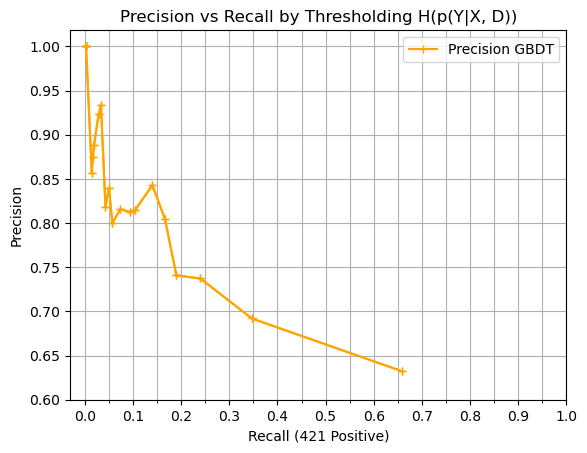

In [20]:
threshs = u
ens_preds = pred
std_threshs = np.linspace(np.min(threshs), np.max(threshs), 20)
reject_rate = [1 - np.mean((threshs<=s)) for s in std_threshs]
accus = [np.mean((ens_preds==Y_ext)[(threshs<=s)]) for s in std_threshs]
tps = [np.sum(((Y_ext)*(ens_preds==Y_ext))[(threshs<=s)]) for s in std_threshs]  # correct and positive
fps = [np.sum(((ens_preds)*(ens_preds!=Y_ext))[(threshs<=s)]) for s in std_threshs]  # incorrect and predicted positive
pos = np.sum(Y_ext)
recall = [tp/pos for tp in tps]
precision = [tp/(tp+fp) for tp, fp in zip(tps, fps)]
plt.plot(recall, precision, marker='+', c='orange')

plt.plot(recall, precision, marker='+', c='orange')
plt.xticks(np.arange(0, 1.01, step=0.1))
plt.xticks(np.arange(0, 1.01, step=0.05), minor=True)
plt.yticks(np.arange(.6, 1.01, step=0.05))
plt.grid(True, which='both')
plt.xlabel('Recall ({} Positive)'.format(int(pos)))
plt.ylabel('Precision')
plt.title('Precision vs Recall by Thresholding H(p(Y|X, D))')
plt.legend(['Precision GBDT'])